# Adam

## Definition: Adam (Adaptive Moment Estimation)

Adam (Kingma & Ba, 2015) combines two ideas:
1. **Momentum** (an exponential moving average of past gradients), and  
2. **RMSProp-like adaptive scaling** (an exponential moving average of squared gradients).

This allows Adam to adapt the step size **per parameter** while also smoothing
noisy gradients using momentum. Adam is one of the most widely used optimizers
in deep learning because it is stable, inexpensive, and works well across a
variety of architectures.

Given the gradient at step $t$:
$$
g_t = \nabla_\theta L(\theta_t),
$$
Adam maintains two exponential moving averages:
- the **first moment** (momentum):
  $$
  m_t = \beta_1 m_{t-1} + (1 - \beta_1)\, g_t,
  $$
- the **second moment** (RMS-like accumulation):
  $$
  v_t = \beta_2 v_{t-1} + (1 - \beta_2)\, g_t^2,
  $$
where the square is taken componentwise. The values $\beta_1, \beta_2\in (0,1)$ are called first and second moment decay rates respectivetly. 


Because $m_t$ and $v_t$ start at zero, they are biased toward zero early in
training. Adam applies **bias correction**:
$$
\hat m_t = \frac{m_t}{1 - \beta_1^{t}}, \qquad
\hat v_t = \frac{v_t}{1 - \beta_2^{t}}.
$$

The parameter update is then
$$
\theta_{t+1}
= \theta_t
- \eta\,
\frac{\hat m_t}{\sqrt{\hat v_t} + \varepsilon},
$$
where:
- $\eta > 0$ is the learning rate,
- $\varepsilon > 0$ is a stability constant.

### Interpretation
- The first moment $\hat m_t$ behaves like **momentum**, smoothing the direction.  
- The second moment $\hat v_t$ behaves like RMSProp, shrinking steps in
  coordinates with large or unstable gradients.  
- The ratio  
  $$
  \hat m_t / \sqrt{\hat v_t}
  $$  
  combines these two effects to produce a **scaled, stabilized direction**.

This makes Adam robust to noisy gradients, gradient scale differences, and
ill-conditioned curvature, which is why it is the default choice in many deep
learning applications.

## Code: Adam

In [28]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.optim.optimizer import Optimizer

from model.mlp import MLP

In [29]:
class Adam(Optimizer):
    """
    Basic Adam optimizer (Kingma & Ba, 2015) with bias correction.
    """
    
    def __init__(
        self,
        params,
        lr: float = 1e-3,
        betas: tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-8,
        weight_decay: float = 0.0,
    ):
        if lr <= 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        beta1, beta2 = betas
        if not (0.0 < beta1 < 1.0 and 0.0 < beta2 < 1.0):
            raise ValueError(f"Invalid beta values: {betas}")
        if eps <= 0.0:
            raise ValueError(f"Invalid eps: {eps}")
        if weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay: {weight_decay}")

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        """Performs a single Adam update step."""
        for group in self.param_groups:
            lr = group["lr"]
            beta1, beta2 = group["betas"]
            eps = group["eps"]
            weight_decay = group["weight_decay"]

            for p in group["params"]:
                grad = p.grad
                if grad is None:
                    continue

                # Apply L2 weight decay (same style as torch.optim.Adam)
                if weight_decay != 0.0:
                    grad = grad.add(p, alpha=weight_decay)

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    state["m"] = torch.zeros_like(p)  # first moment
                    state["v"] = torch.zeros_like(p)  # second moment

                m = state["m"]
                v = state["v"]
                state["step"] += 1
                t = state["step"]

                # 1) Update biased first and second moments
                # m_t = β1 m_{t-1} + (1 - β1) g_t      # first moment (momentum-like)
                # v_t = β2 v_{t-1} + (1 - β2) g_t^2    # second moment (variance-like)
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                v.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # 2) Compute bias-corrected moments
                # m̂_t = m_t / (1 - β1^t)
                # v̂_t = v_t / (1 - β2^t)
                bias_correction1 = 1 - beta1**t
                bias_correction2 = 1 - beta2**t
                m_hat = m / bias_correction1
                v_hat = v / bias_correction2

                # 3) Parameter update
                # θ_{t+1} = θ_t - lr * m̂_t / (sqrt(v̂_t) + ε)
                p.addcdiv_(m_hat, v_hat.sqrt().add_(eps), value=-lr)

### Data

In [30]:
def f(x):
    return 1+2*x**2

N = 20
xs = (4*torch.rand(N)-2).unsqueeze(1)
ys = f(xs) + 0.5*torch.randn(N).unsqueeze(1)

x = torch.linspace(-2,2,100,requires_grad=True)
x_eval = torch.linspace(-2,2,100)
torch.manual_seed(1)

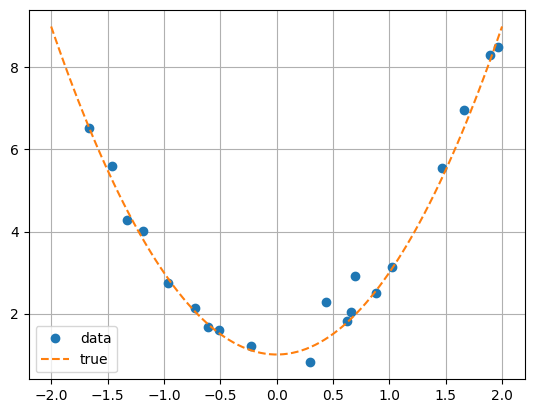

In [31]:
plt.plot(xs.detach().numpy(), ys.detach().numpy(), 'o',label='data')
plt.plot(x.detach().numpy(), f(x).detach().numpy(), '--',label='true')
plt.legend()
plt.grid()
plt.show()


### Training loop

In [32]:
def train(model, opt, loss_fn, data, epochs=20, batch_size=1):
    xs, ys = data
    N = xs.shape[0]
    model.train()
    losses = []
    for epoch in range(epochs):
        perm = torch.randperm(N)  # shuffle for stochasticity each epoch
        for i in range(0, N, batch_size):
            batch_idx = perm[i:i + batch_size]
            x = xs[batch_idx]
            y = ys[batch_idx]
            opt.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
        losses.append(loss.item())
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")   
    return losses

def compare_losses(loss,nn_loss,title):
    plt.plot(nn_loss,linestyle="-",label="nn_loss")
    plt.plot(loss,linestyle="--",label="loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

## Parameters

In [33]:
lr = 0.001
betas = (0.95, 0.99)
eps = 1e-8
weight_decay = 0.01

loss_fn = nn.MSELoss()  

### pytorch

In [34]:
torch.manual_seed(1)
model = MLP(input_dim=1,output_dim=1,hidden_dims=[512,512,512],activation=nn.Tanh())
opt = torch.optim.Adam(model.parameters(),
          lr=lr,
          weight_decay=weight_decay,
)

nn_loss = train(model,opt,loss_fn,(xs,ys),epochs=150,batch_size=N)

Epoch 1/150, Loss: 19.1659
Epoch 2/150, Loss: 9.5229
Epoch 3/150, Loss: 7.1732
Epoch 4/150, Loss: 8.3355
Epoch 5/150, Loss: 6.5234
Epoch 6/150, Loss: 5.1101
Epoch 7/150, Loss: 6.0650
Epoch 8/150, Loss: 5.0554
Epoch 9/150, Loss: 3.4733
Epoch 10/150, Loss: 3.3615
Epoch 11/150, Loss: 3.4207
Epoch 12/150, Loss: 2.5372
Epoch 13/150, Loss: 1.5679
Epoch 14/150, Loss: 1.5572
Epoch 15/150, Loss: 1.6660
Epoch 16/150, Loss: 1.0310
Epoch 17/150, Loss: 0.6383
Epoch 18/150, Loss: 0.9435
Epoch 19/150, Loss: 1.0729
Epoch 20/150, Loss: 0.7792
Epoch 21/150, Loss: 0.7590
Epoch 22/150, Loss: 1.0451
Epoch 23/150, Loss: 0.9693
Epoch 24/150, Loss: 0.6818
Epoch 25/150, Loss: 0.6476
Epoch 26/150, Loss: 0.6891
Epoch 27/150, Loss: 0.5329
Epoch 28/150, Loss: 0.3505
Epoch 29/150, Loss: 0.3597
Epoch 30/150, Loss: 0.4457
Epoch 31/150, Loss: 0.4252
Epoch 32/150, Loss: 0.3596
Epoch 33/150, Loss: 0.3765
Epoch 34/150, Loss: 0.4334
Epoch 35/150, Loss: 0.4158
Epoch 36/150, Loss: 0.3324
Epoch 37/150, Loss: 0.2814
Epoch 38/

### Custom

Epoch 1/150, Loss: 19.1659
Epoch 2/150, Loss: 9.5229
Epoch 3/150, Loss: 7.1732
Epoch 4/150, Loss: 8.3355
Epoch 5/150, Loss: 6.5234
Epoch 6/150, Loss: 5.1101
Epoch 7/150, Loss: 6.0650
Epoch 8/150, Loss: 5.0554
Epoch 9/150, Loss: 3.4733
Epoch 10/150, Loss: 3.3615
Epoch 11/150, Loss: 3.4207
Epoch 12/150, Loss: 2.5372
Epoch 13/150, Loss: 1.5679
Epoch 14/150, Loss: 1.5572
Epoch 15/150, Loss: 1.6660
Epoch 16/150, Loss: 1.0310
Epoch 17/150, Loss: 0.6383
Epoch 18/150, Loss: 0.9435
Epoch 19/150, Loss: 1.0729
Epoch 20/150, Loss: 0.7792
Epoch 21/150, Loss: 0.7590
Epoch 22/150, Loss: 1.0451
Epoch 23/150, Loss: 0.9693
Epoch 24/150, Loss: 0.6818
Epoch 25/150, Loss: 0.6476
Epoch 26/150, Loss: 0.6891
Epoch 27/150, Loss: 0.5329
Epoch 28/150, Loss: 0.3505
Epoch 29/150, Loss: 0.3597
Epoch 30/150, Loss: 0.4457
Epoch 31/150, Loss: 0.4252
Epoch 32/150, Loss: 0.3596
Epoch 33/150, Loss: 0.3765
Epoch 34/150, Loss: 0.4334
Epoch 35/150, Loss: 0.4158
Epoch 36/150, Loss: 0.3324
Epoch 37/150, Loss: 0.2814
Epoch 38/

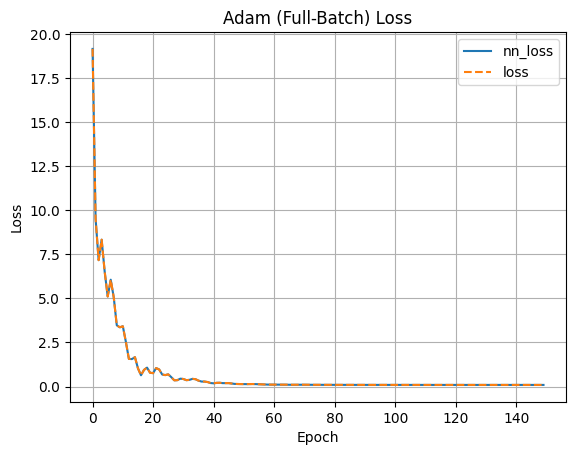

In [35]:
torch.manual_seed(1)
model = MLP(input_dim=1,output_dim=1,hidden_dims=[512,512,512],activation=nn.Tanh())
opt = Adam(model.parameters(),
          lr=lr,
          weight_decay=weight_decay,
)

loss = train(model,opt,loss_fn,(xs,ys),epochs=150,batch_size=N)
compare_losses(loss,nn_loss,"Adam (Full-Batch) Loss")

# Evaluation

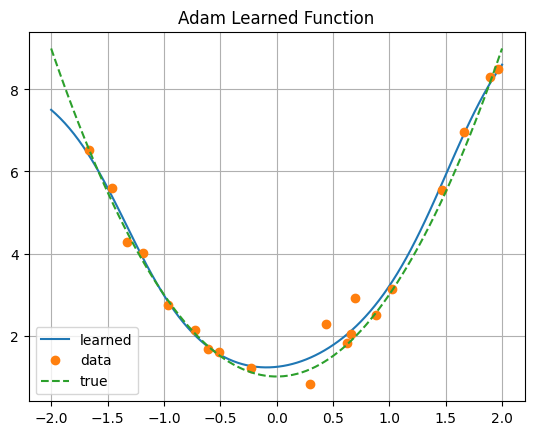

In [36]:
plt.plot(x_eval,model(x_eval[:,None]).squeeze().detach().numpy(), '-',label='learned')
plt.plot(xs.detach().numpy(), ys.detach().numpy(), 'o',label='data')
plt.plot(x_eval,f(x_eval), '--',label='true')
plt.title("Adam Learned Function")
plt.legend()
plt.grid()
plt.show()